In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
import time

from model import Model
from dataset import WheatAwnDataset

from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import PIL
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix

### This Notebook will be used to Evaluate Trained Models on Testing Data
-both 2020 and 2019 testing data will be used<br/>-we will also use it to visualize model performance<br/>-we can also directly compare variout trained models<br/>-each evaluation block will start with a markdown cell containing the **"path/to/the/model's/state_dtict.pth"** file as well as the hyper parmeters used

In [14]:
#sort image files (accuracy vs loss plots)
search_dir = "/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/"
os.chdir(search_dir)
plot_files = filter(os.path.isfile, os.listdir(search_dir))
plot_files = [os.path.join(search_dir, f) for f in plot_files]# add path to each file

plot_files = [file for file in plot_files if file.endswith('.jpg')]
plot_files.sort(key=lambda x: os.path.getmtime(x))

for file in plot_files:
    print(f"file: {file.split('/')[-1]}\n time: {datetime.fromtimestamp(os.path.getmtime(file))}\n")

file: test_loss_accuracy-plot.jpg
 time: 2021-10-17 14:56:08.634031

file: 2021-10-17-15_24_58_loss_accuracy-plot.jpg
 time: 2021-10-17 15:24:58.844047

file: 2021-10-17-15_27_56_loss_accuracy-plot.jpg
 time: 2021-10-17 15:27:56.908515

file: 2021-10-17-16_03_58_loss_accuracy-plot.jpg
 time: 2021-10-17 16:03:58.574784

file: 2021-10-19-12_20_00_loss_accuracy-plot.jpg
 time: 2021-10-19 12:23:38.676288

file: 2021-10-19-12_43_19_loss_accuracy-plot.jpg
 time: 2021-10-19 12:43:48.781290

file: 2021-10-19-12_45_24_loss_accuracy-plot.jpg
 time: 2021-10-19 12:45:53.247819

file: 2021-10-19-12_47_53_loss_accuracy-plot.jpg
 time: 2021-10-19 12:48:22.072233

file: 2021-10-19-12_49_28_loss_accuracy-plot.jpg
 time: 2021-10-19 12:49:58.360736

file: 2021-10-19-13_01_59_loss_accuracy-plot.jpg
 time: 2021-10-19 13:02:28.148023

file: 2021-10-19-13_04_30_loss_accuracy-plot.jpg
 time: 2021-10-19 13:04:53.676319

file: 2021-10-19-13_05_34_loss_accuracy-plot.jpg
 time: 2021-10-19 13:06:02.199813

file: 2

In [15]:
#sort state_dict (.pth) files in runs dir
search_dir = "/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/"
os.chdir(search_dir)
pth_files = filter(os.path.isfile, os.listdir(search_dir))
pth_files = [os.path.join(search_dir, f) for f in pth_files]# add path to each file

pth_files = [file for file in pth_files if file.endswith('.pth')] #only get model files
pth_files.sort(key=lambda x: os.path.getmtime(x))

for file in pth_files:
    print(f"file: {file.split('/')[-1]}\n time: {datetime.fromtimestamp(os.path.getmtime(file))}\n")

file: 2021-10-19-12_20_00_model_epoch-49.pth
 time: 2021-10-19 12:23:37.758255

file: 2021-10-19-12_43_19_model_epoch-4.pth
 time: 2021-10-19 12:43:48.164268

file: 2021-10-19-12_45_24_model_epoch-4.pth
 time: 2021-10-19 12:45:52.731800

file: 2021-10-19-12_47_53_model_epoch-4.pth
 time: 2021-10-19 12:48:21.319206

file: 2021-10-19-12_49_28_model_epoch-4.pth
 time: 2021-10-19 12:49:57.838717

file: 2021-10-19-12_57_38_model_epoch-4.pth
 time: 2021-10-19 12:58:07.381533

file: 2021-10-19-13_01_59_model_epoch-4.pth
 time: 2021-10-19 13:02:27.611003

file: 2021-10-19-13_04_30_model_epoch-4.pth
 time: 2021-10-19 13:04:53.291305

file: 2021-10-19-13_05_34_model_epoch-4.pth
 time: 2021-10-19 13:06:01.809799

file: 2021-10-19-13_16_11_model_epoch-4.pth
 time: 2021-10-19 13:16:40.168007

file: 2021-10-19-21_50_36_model_epoch-4.pth
 time: 2021-10-19 21:51:32.037350

file: 2021-10-19-21_51_55_model_epoch-4.pth
 time: 2021-10-19 21:52:50.356331

file: 2021-10-20-06_44_27_model_epoch-5.pth
 time: 

### model training: 2021-10-20
**lr** = 0.00001 (no scheduler)<br/>**batch_size** = 32<br/>**epochs** = 10<br/>**train dataset:** '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_train_awns_oversampled.csv' (but actually imbalanced :P)<br/>**validation dataset:** '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_test_awns.csv'<br/>**model state_dict:** '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/2021-10-20-06_44_27_model_epoch-9.pth'


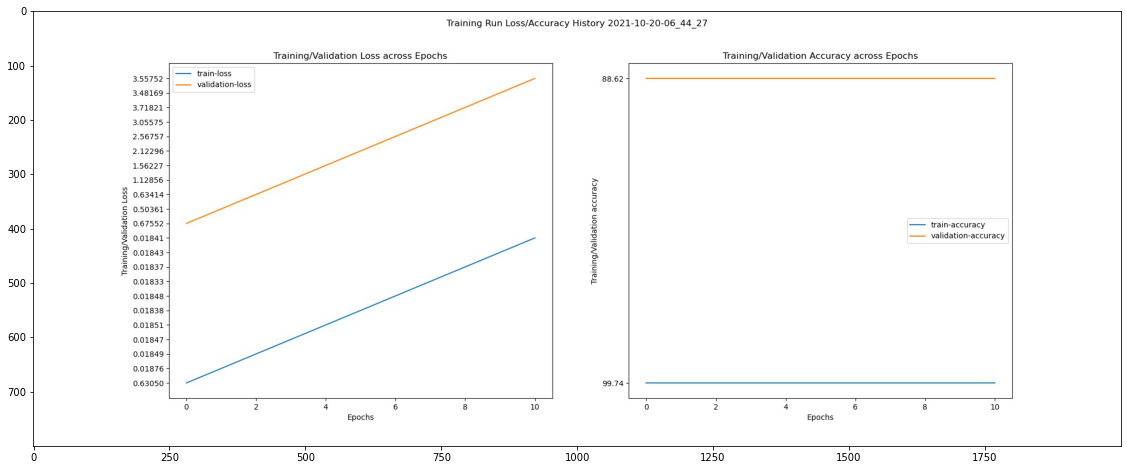

In [16]:
#raining history plot for the run
plot_img = PIL.Image.open(plot_files[-1])
plt.figure(figsize = (20,8))
plt.imshow(plot_img)

In [37]:
#instantiate the model
print(f"loading model from: {pth_files[-1]}")
saved_model = Model().construct_model(verbose=False)
saved_model.load_state_dict(torch.load(pth_files[-1]))

loading model from: /pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/runs/2021-10-20-06_44_27_model_epoch-9.pth


<All keys matched successfully>

In [38]:
#send the model to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
saved_model = saved_model.to(device)

#### verify the accuracy acheived on the validation set (used during training)

In [4]:
#collect test dataset and create loader iterable-object
dataset_path = '/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/'
data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_train_awns_oversampled.csv'
batch_size = 32

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([77.7395, 83.9253, 53.3458], [48.1450, 49.1999, 36.7069])])

data = WheatAwnDataset(csv_filepath=data_csv, dataset_dir=dataset_path, transform=transform)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

data file "2019_train_awns_oversampled.csv" contains 897456 rows


In [26]:
#track the correct predictions
corrects = 0.0

#set model mode
saved_model.eval()

#make sure to not accumulate gradients
with torch.no_grad():
    
    progress_bar = tqdm(dataloader, total=int(len(dataloader)), desc='[validation] Progress: ')

    for step, data in enumerate(progress_bar):

        #unpack the data from the progress bar
        images, labels = data[0], data[1]

        #send the tensors to the device (GPU)
        images = images.to(device)
        labels = labels.to(device)

        #images = images.float() #uncomment if using read_image() from torch
        outputs = saved_model(images)

        #find the predicted classes indicies
        _, preds = torch.max(outputs, 1)

        #track the correct predictions
        corrects += torch.sum(preds == labels.data).item()

[validation] Progress: 100%|██████████| 10858/10858 [14:35<00:00, 12.41it/s]


In [27]:
#calculate the accuracy 
accuracy = (corrects/len(dataloader.dataset))*100
accuracy = "{:5.2f}".format(accuracy)
print("accuracy: ", accuracy)

accuracy:  88.62


In [40]:
# Get the predictions
predictions = []
ground_truths = []

progress_bar = tqdm(dataloader, total=int(len(dataloader)), desc='[test] Progress: ')

#set model mode
saved_model.eval()

for step, data in enumerate(progress_bar):
    
    #unpack the data from the progress bar
    images, labels = data[0], data[1]
    
    images = images.to(device)
    
    outputs = saved_model(images)
    _, preds = torch.max(outputs, 1)
    
    ground_truths.extend(list(labels.numpy()))
    predictions.extend(list(preds.cpu().numpy()))

print("predictions:   ", len(predictions))
print("ground truths: ", len(ground_truths))

[test] Progress: 100%|██████████| 2715/2715 [11:48<00:00,  3.83it/s]

predictions:    86863
ground truths:  86863


In [41]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=ground_truths, y_pred=predictions)

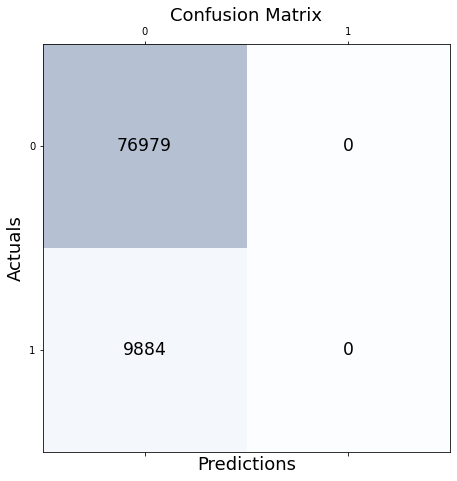

In [42]:
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

#### determine the accuracy on the test set

In [29]:
#collect test dataset and create loader iterable-object
dataset_path = '/pless_nfs/home/matthewrberning/multi-year-cult-class/data/preprocessed/'
data_csv = '/pless_nfs/home/matthewrberning/wheat-awn-classification-multiyear/data/2019_val_awns.csv'
batch_size = 32

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([77.7395, 83.9253, 53.3458], [48.1450, 49.1999, 36.7069])])

data = WheatAwnDataset(csv_filepath=data_csv, dataset_dir=dataset_path, transform=transform)
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [30]:
#track the correct predictions
corrects = 0.0

#set model mode
saved_model.eval()

#make sure to not accumulate gradients
with torch.no_grad():
    
    progress_bar = tqdm(dataloader, total=int(len(dataloader)), desc='[test] Progress: ')

    for step, data in enumerate(progress_bar):

        #unpack the data from the progress bar
        images, labels = data[0], data[1]

        #send the tensors to the device (GPU)
        images = images.to(device)
        labels = labels.to(device)

        #images = images.float() #uncomment if using read_image() from torch
        outputs = saved_model(images)

        #find the predicted classes indicies
        _, preds = torch.max(outputs, 1)

        #track the correct predictions
        corrects += torch.sum(preds == labels.data).item()

[test] Progress: 100%|██████████| 1026/1026 [09:34<00:00,  1.79it/s]


In [31]:
#calculate the accuracy 
accuracy = (corrects/len(dataloader.dataset))*100
accuracy = "{:5.2f}".format(accuracy)
print("accuracy: ", accuracy)

accuracy:  93.22


In [32]:
# Get the predictions
predictions = []
ground_truths = []

progress_bar = tqdm(dataloader, total=int(len(dataloader)), desc='[test] Progress: ')

#set model mode
saved_model.eval()

for step, data in enumerate(progress_bar):
    
    #unpack the data from the progress bar
    images, labels = data[0], data[1]
    
    images = images.to(device)
    
    outputs = saved_model(images)
    _, preds = torch.max(outputs, 1)
    
    ground_truths.extend(list(labels.numpy()))
    predictions.extend(list(preds.cpu().numpy()))

print("predictions:   ", len(predictions))
print("ground truths: ", len(ground_truths))

[test] Progress: 100%|██████████| 1026/1026 [04:34<00:00,  3.74it/s]

predictions:    32809
ground truths:  32809


In [33]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=ground_truths, y_pred=predictions)

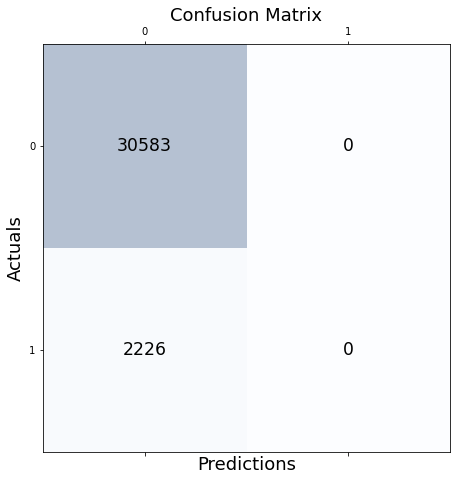

In [34]:
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [5]:
for epoch in range(10):
    if epoch%1 == 0 and epoch != 0:
        print(epoch, " saving")

1  saving
2  saving
3  saving
4  saving
5  saving
6  saving
7  saving
8  saving
9  saving


In [6]:
a =99.109201273128301298

In [19]:
print(f"a= {a:.3f}")

a= 99.109


Factor =  0.95  , Learning Rate =  0.0001
Factor =  0.95  , Learning Rate =  6.500000000000001e-05
Factor =  0.95  , Learning Rate =  2.7462500000000007e-05
Factor =  0.95  , Learning Rate =  7.541889062500002e-06
Factor =  0.95  , Learning Rate =  1.3462743344628912e-06
Factor =  0.95  , Learning Rate =  1.5620694889554074e-07
Factor =  0.95  , Learning Rate =  1.1780954793617754e-08
Factor =  0.95  , Learning Rate =  5.775292516746526e-10
Factor =  0.95  , Learning Rate =  1.8402670033873242e-11
Factor =  0.95  , Learning Rate =  3.811544977260444e-13


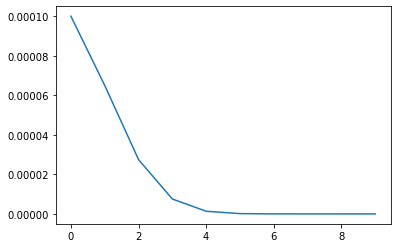

In [22]:
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
lmbda = lambda epoch: 0.65 ** epoch
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
lrs = []

for i in range(10):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    print("Factor = ",0.95," , Learning Rate = ",optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(range(10),lrs)